## Multi-task approach
***

Este notebook es un primer intento para usar un enfoque multitasking que permita predecir valores reales (Regresión) y también clasificar cuando tenemos un conjunto de valores finitos asociados a algún parámetro estelar.

In [130]:
import os
import sys
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns

## Descarga de datos

In [131]:
# Dataset provided by PhD (c) Daniela Turis, IFA-UV.

# Verifica si estás en Google Colab
IN_COLAB = 'google.colab' in sys.modules

if IN_COLAB:
    # En Colab, usamos gdown
    import gdown
    !gdown https://drive.google.com/uc?id=14NHeV1fvE2HXMaghHAszf_92iTBVNJHL
    !gdown  https://drive.google.com/uc?id=1g56JSd46v1HjJkhpIw7Qkal--VDd7cpS
    !gdown  https://drive.google.com/uc?id=1YA9HYeOKHMYvt9M4LAaLkO8mpJjOXktV

    data = np.load("subset_vmic10.npy")
    y = np.load("y_subset_vmic10.npy")

else:
    # En entorno local, carga desde disco
    dir_path = "/Users/rpezoa/experiment_data/data_fo/data_vmic10/"
    if os.path.exists(dir_path):
        print("Archivo cargado localmente:", dir_path + "subset_vmic10.npy")
        data = np.load(dir_path + "subset_vmic10.npy")
        y = np.load(dir_path + "y_subset_vmic10.npy")
        data_observed = np.load("/Users/rpezoa/experiment_data/data_fo/data/X_observed.npy")
        data_observed_p = np.load("/Users/rpezoa/experiment_data/data_fo/data/X_observed_processed.npy")


    else:
        print("No se encontró el archivo local. Debes descargarlo manualmente.")

Archivo cargado localmente: /Users/rpezoa/experiment_data/data_fo/data_vmic10/subset_vmic10.npy


## Gráfico de una línea sintética

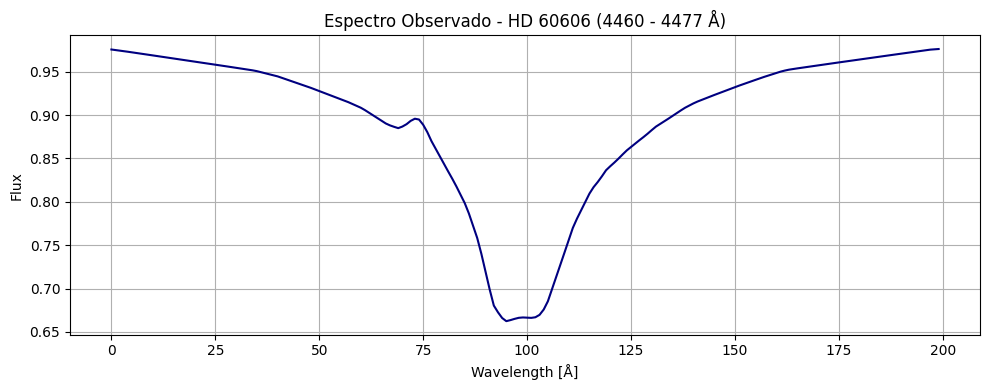

In [3]:
i = 1503
# Graficar el espectro
plt.figure(figsize=(10, 4))
plt.plot(range(200), data[i,:], color="navy", lw=1.5)
plt.xlabel("Wavelength [Å]")
plt.ylabel("Flux")
plt.title("Espectro Observado - HD 60606 (4460 - 4477 Å)")
plt.grid(True)
plt.tight_layout()
# Guardar a archivo PNG
plt.savefig("spectrum_hd60606_4460_4477.png", dpi=300)
plt.show()

In [36]:
y_new = y[:, [0, 1, 7]]

### Escalamiento de datos

* Solo escalamos valores reales, para la tarea de regresión

In [132]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

scaler1 = MinMaxScaler(feature_range=(0, 1))
scaler1.fit(y_new[:,[0,2]])
yreg_scaled = scaler1.transform(y_new[:,[0,2]])




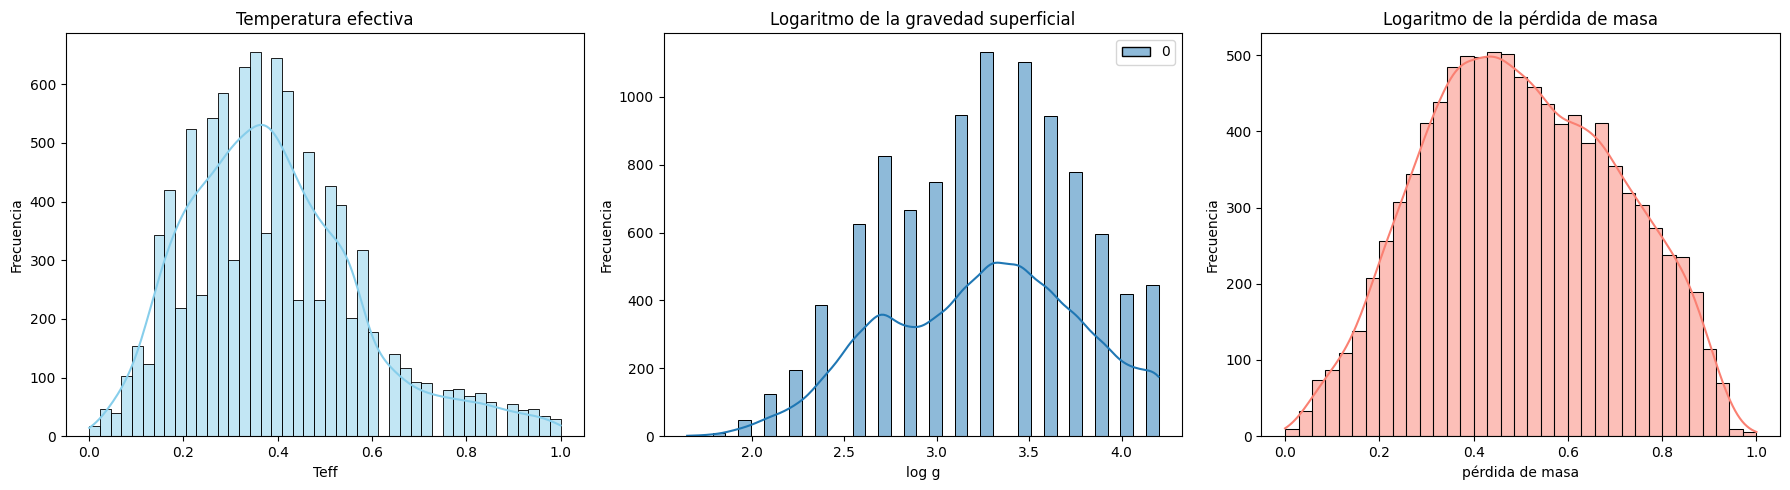

In [133]:
# Crear la figura con 3 subgráficos en una fila
fig, axes = plt.subplots(1, 3, figsize=(18, 5))  # 1 fila, 3 columnas

# Primer histograma
sns.histplot(yreg_scaled[:, 0], kde=True, color="skyblue", ax=axes[0])
axes[0].set_title("Temperatura efectiva")
axes[0].set_xlabel("Teff")
axes[0].set_ylabel("Frecuencia")

# Segundo histograma
sns.histplot(y_new[:,[1]], kde=True, color="lightgreen", ax=axes[1])
axes[1].set_title("Logaritmo de la gravedad superficial")
axes[1].set_xlabel("log g")
axes[1].set_ylabel("Frecuencia")

# Tercer histograma
sns.histplot(yreg_scaled[:, 1], kde=True, color="salmon", ax=axes[2])
axes[2].set_title("Logaritmo de la pérdida de masa")
axes[2].set_xlabel("pérdida de masa")
axes[2].set_ylabel("Frecuencia")

# Ajustar el espaciado
plt.tight_layout()
plt.show()

In [61]:
# Asegurarse de que y_clf tenga forma (N, 1)
y_clf_reshaped = y_new[:,[1]].reshape(-1, 1)

# Extraer columnas específicas de y_reg
teff = yreg_scaled[:, 0].reshape(-1, 1)
logmdot = yreg_scaled[:, 1].reshape(-1, 1)




In [67]:
y_logg_real = y_new[:, 1]  # o y_new[:,1].flatten()

# Crear el diccionario como antes
logg_unique = np.unique(y_logg_real)
logg_to_index = {val: idx for idx, val in enumerate(logg_unique)}

# Aplicar el mapeo
y_clf = np.array([logg_to_index[val] for val in y_logg_real])

In [134]:
# Concatenar en el orden deseado
y_clf_reshaped = y_clf.reshape(-1, 1)

# Concatenar en el orden deseado
y_concat = np.concatenate((teff, y_clf_reshaped, logmdot), axis=1)

In [135]:
X_train, X_test, y_train, y_test = train_test_split(data, y_concat, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

In [136]:
time_steps = X_train.shape[1]
input_dimension = 1

sample_size = X_train.shape[0]
X_train_reshaped = X_train.reshape((sample_size, time_steps, input_dimension))
sample_size = X_val.shape[0]
X_val_reshaped = X_val.reshape((sample_size, time_steps, input_dimension))
sample_size = X_test.shape[0]
X_test_reshaped = X_test.reshape((sample_size, time_steps, input_dimension))

In [137]:
from sklearn.utils import class_weight
import numpy as np

# Asegúrate de que y_clf sean enteros 0 a 17 (índices de clase)
class_weights = class_weight.compute_class_weight(
    class_weight="balanced",
    classes=np.arange(18),
    y=y_train[:,1]
)

# Diccionario que se pasa a model.fit
class_weight_dict = {i: w for i, w in enumerate(class_weights)}


In [140]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, Model, Input

def build_multitask_conv1D_model(n_classes_logg=18):
    n_timesteps = X_train_reshaped.shape[1]
    n_features  = X_train_reshaped.shape[2]

    inputs = Input(shape=(n_timesteps, n_features), name="input_layer")

    x = layers.Conv1D(filters=32, kernel_size=7, activation='relu', name="Conv1D_1")(inputs)
    x = layers.Conv1D(filters=16, kernel_size=3, activation='relu', name="Conv1D_2")(x)
    x = layers.Flatten()(x)
    x = layers.Dense(32, activation="selu", name="Dense_shared")(x)

    # Rama regresión: Teff y log Ṁ
    reg_output = layers.Dense(2, activation="linear", name="regression_output")(x)

    # Rama clasificación: log g con softmax
    clf_output = layers.Dense(n_classes_logg, activation="softmax", name="classification_output")(x)

    model = Model(inputs=inputs, outputs=[reg_output, clf_output], name="model_conv1D_multitask")

    model.compile(
        loss={
            "regression_output": "mse",
            "classification_output": "sparse_categorical_crossentropy"
        },
        optimizer=tf.keras.optimizers.RMSprop(0.001),
        metrics={
            "regression_output": "mae",
            "classification_output": "accuracy" # Hay que cambiar esta métrica
        }
    )

    return model

model_conv1D = build_multitask_conv1D_model()
model_conv1D.summary()


Model: "model_conv1D_multitask"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 200, 1)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1D_1 (Conv1D)   │ (None, 194, 32)   │        256 │ input_layer[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1D_2 (Conv1D)   │ (None, 192, 16)   │      1,552 │ Conv1D_1[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_5 (Flatten) │ (None, 3072)      │          0 │ Conv1D_2[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Dense_shared        │ (None, 32)        │     98,336 │ flatten_5[0][0]   │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ regression_output   │ (None, 2)         │         66 │ Dense_shared[0][… │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ classification_out… │ (None, 18)        │        594 │ Dense_shared[0][… │
│ (Dense)             │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 100,804 (393.77 KB)

 Trainable params: 100,804 (393.77 KB)

 Non-trainable params: 0 (0.00 B)

In [139]:
y_train_reg = y_train[:,[0,2]]
y_train_clf = y_train[:,1]

y_val_reg = y_val[:,[0,2]]
y_val_clf = y_val[:,1]

history = model_conv1D.fit(
    X_train_reshaped,
    {"regression_output": y_train_reg, "classification_output": y_train_clf},
    validation_data=(X_val_reshaped, {"regression_output": y_val_reg, "classification_output": y_val_clf}),
    epochs=50,
    batch_size=32
)

Epoch 1/50
200/200 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - classification_output_accuracy: 0.0980 - classification_output_loss: 2.7080 - loss: 2.7705 - regression_output_loss: 0.0625 - regression_output_mae: 0.1797 - val_classification_output_accuracy: 0.1250 - val_classification_output_loss: 2.5996 - val_loss: 2.6287 - val_regression_output_loss: 0.0291 - val_regression_output_mae: 0.1331
Epoch 2/50
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - classification_output_accuracy: 0.1152 - classification_output_loss: 2.6038 - loss: 2.6304 - regression_output_loss: 0.0266 - regression_output_mae: 0.1264 - val_classification_output_accuracy: 0.1631 - val_classification_output_loss: 2.5020 - val_loss: 2.5232 - val_regression_output_loss: 0.0212 - val_regression_output_mae: 0.1058
Epoch 3/50
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - classification_output_accuracy: 0.1591 - classification_output_loss: 2.4705 - loss: 2.5023 - regression_output_loss: 0.0319 - regression_output_mae: 0.1317 - val_classifi

In [78]:
y_pred_reg, y_pred_clf = model_conv1D.predict(X_test_reshaped)

63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


In [79]:
y_pred_reg

array([[0.38950974, 0.24278018],
       [0.36847615, 0.19267115],
       [0.80852485, 0.27616382],
       ...,
       [0.63041097, 0.7358557 ],
       [0.10530506, 0.4067746 ],
       [0.5376976 , 0.601393  ]], dtype=float32)

In [80]:
y_pred_reg_inv = scaler1.inverse_transform(y_pred_reg)

In [81]:
y_pred_reg_inv

array([[ 2.3022350e+04, -9.7835999e+00],
       [ 2.2265141e+04, -1.0101019e+01],
       [ 3.8106895e+04, -9.5721283e+00],
       ...,
       [ 3.1694795e+04, -6.6601791e+00],
       [ 1.2790982e+04, -8.7447662e+00],
       [ 2.8357113e+04, -7.5119424e+00]], dtype=float32)

In [82]:
y_pred_clf

array([[7.7550000e-14, 4.7372753e-17, 1.8994940e-15, ..., 7.3300079e-02,
        8.6355852e-03, 8.7216793e-04],
       [3.2037003e-13, 4.3257216e-16, 1.6138919e-14, ..., 1.7112035e-02,
        1.6097835e-03, 6.7892186e-05],
       [1.4922171e-22, 2.6741667e-28, 4.6358599e-25, ..., 6.3535136e-01,
        7.5056955e-02, 5.3376830e-03],
       ...,
       [2.1665723e-09, 1.8804002e-11, 4.7149925e-13, ..., 2.0892473e-02,
        1.0417151e-05, 1.4607573e-08],
       [3.8378883e-11, 5.3232810e-07, 2.6626423e-05, ..., 2.6713534e-22,
        2.6184105e-26, 2.1869646e-32],
       [6.8549664e-13, 5.9989891e-16, 1.4536423e-16, ..., 9.1616273e-02,
        1.4070245e-03, 1.5841681e-05]], dtype=float32)

In [84]:
pred_class = np.argmax(y_pred_clf, axis=1)  # Clase más probable

In [85]:
pred_class

array([13, 13, 15, ..., 14,  5, 14])

In [110]:
y_test[:,1]

array([13., 12., 14., ..., 14.,  5., 14.])

In [87]:
logg_pred_real = logg_unique[pred_class]

In [101]:
# predicción final del logaritmo
logg_pred_real.shape

(2000,)

In [93]:

y_test.shape

(2000, 3)

In [94]:

a = scaler1.inverse_transform(y_test[:,[0,2]])


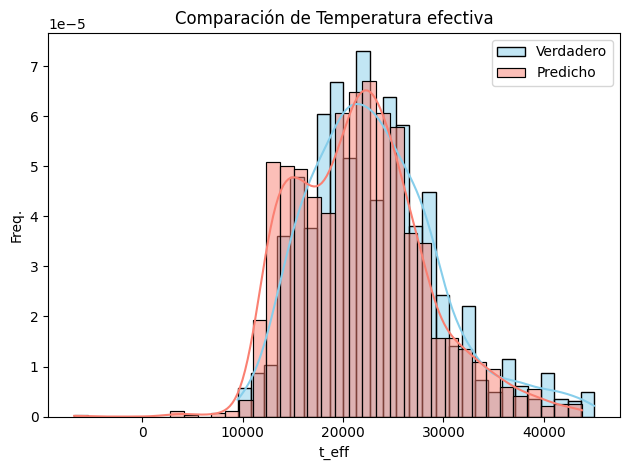

In [97]:


# Histograma 1
sns.histplot(a[:,0], kde=True, color="skyblue", label="Verdadero", stat="density")

# Histograma 2
sns.histplot(y_pred_reg_inv[:,0], kde=True, color="salmon", label="Predicho", stat="density")

plt.title("Comparación de Temperatura efectiva")
plt.xlabel("t_eff")
plt.ylabel("Freq.")
plt.legend()
plt.tight_layout()
plt.show()



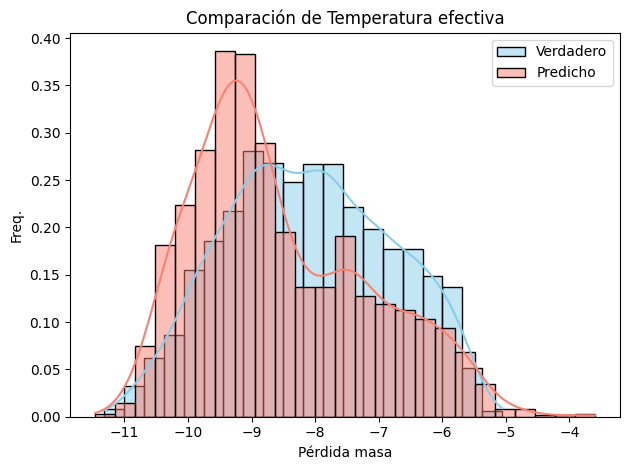

In [100]:
# Histograma 1
sns.histplot(a[:,1], kde=True, color="skyblue", label="Verdadero", stat="density")

# Histograma 2
sns.histplot(y_pred_reg_inv[:,1], kde=True, color="salmon", label="Predicho", stat="density")

plt.title("Comparación de Temperatura efectiva")
plt.xlabel("Pérdida masa")
plt.ylabel("Freq.")
plt.legend()
plt.tight_layout()
plt.show()


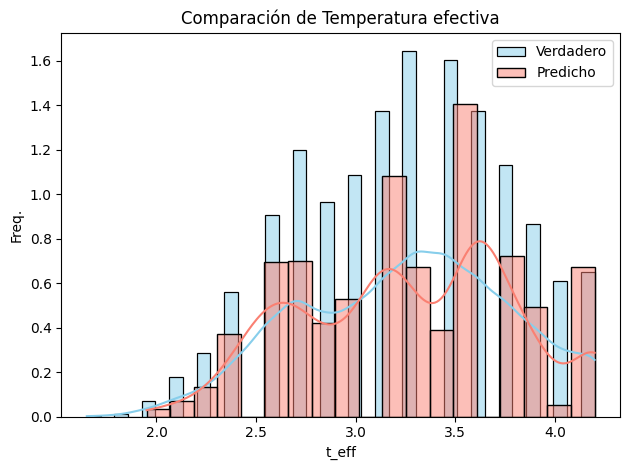

In [103]:
# Histograma 1
sns.histplot(y_logg_real , kde=True, color="skyblue", label="Verdadero", stat="density")

# Histograma 2
sns.histplot(logg_pred_real, kde=True, color="salmon", label="Predicho", stat="density")

plt.title("Comparación de Temperatura efectiva")
plt.xlabel("t_eff")
plt.ylabel("Freq.")
plt.legend()
plt.tight_layout()
plt.show()


In [113]:
y_test

array([[ 0.41666667, 13.        ,  0.34700766],
       [ 0.375     , 12.        ,  0.29900908],
       [ 0.80555556, 14.        ,  0.63628573],
       ...,
       [ 0.88888889, 14.        ,  0.82484339],
       [ 0.13888889,  5.        ,  0.38349349],
       [ 0.56944444, 14.        ,  0.66897348]])

In [118]:

# Vector con los 18 valores posibles
logg_unique = np.array([1.65, 1.8, 1.95, 2.1, 2.25, 2.4, 2.55, 2.7, 2.85, 3.0,
                        3.15, 3.3, 3.45, 3.6, 3.75, 3.9, 4.05, 4.2])



In [127]:
logg_unique.shape

(18,)

In [119]:
y_test[:,1].shape, pred_class.shape

((2000,), (2000,))

In [126]:
np.unique(y_test[:,1]).shape

(17,)

In [ ]:
np.unique(pred_class).shape

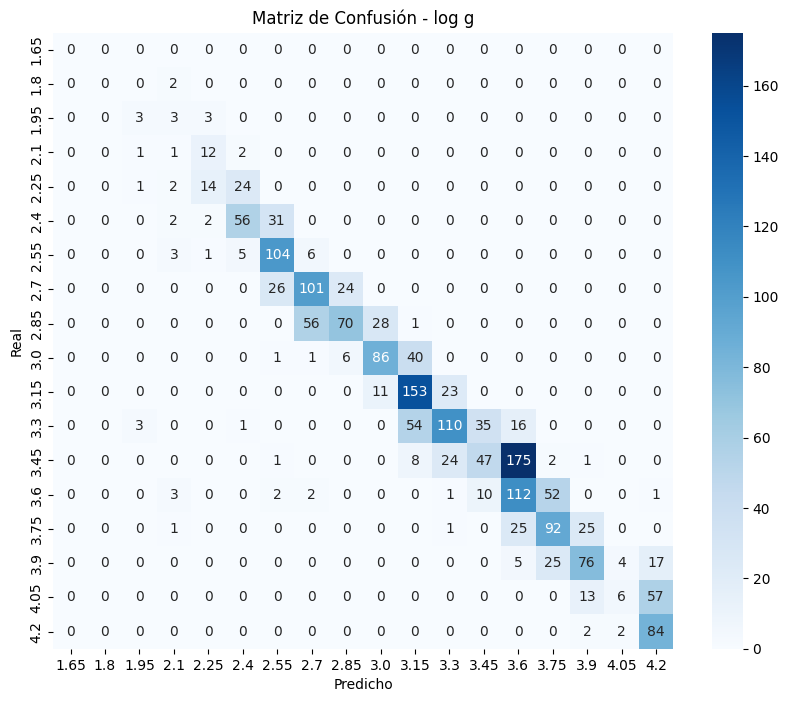

Accuracy: 0.5575
              precision    recall  f1-score   support

         1.0       0.00      0.00      0.00         2
         2.0       0.38      0.33      0.35         9
         3.0       0.06      0.06      0.06        16
         4.0       0.44      0.34      0.38        41
         5.0       0.64      0.62      0.63        91
         6.0       0.63      0.87      0.73       119
         7.0       0.61      0.67      0.64       151
         8.0       0.70      0.45      0.55       155
         9.0       0.69      0.64      0.66       134
        10.0       0.60      0.82      0.69       187
        11.0       0.69      0.50      0.58       219
        12.0       0.51      0.18      0.27       258
        13.0       0.34      0.61      0.43       183
        14.0       0.54      0.64      0.58       144
        15.0       0.65      0.60      0.62       127
        16.0       0.50      0.08      0.14        76
        17.0       0.53      0.95      0.68        88

    accur

/Users/rpezoa/anaconda3/envs/torch-arm/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Users/rpezoa/anaconda3/envs/torch-arm/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Users/rpezoa/anaconda3/envs/torch-arm/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier,

In [123]:
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt

# Matriz de confusión
cm = confusion_matrix(y_test[:,1], pred_class, labels=np.arange(len(logg_unique)))

# Mostrar como heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=logg_unique, yticklabels=logg_unique)
plt.xlabel("Predicho")
plt.ylabel("Real")
plt.title("Matriz de Confusión - log g")
plt.show()

# Accuracy general
acc = accuracy_score(y_test[:,1], pred_class)
print(f"Accuracy: {acc:.4f}")

# Precision, Recall y F1 por clase
print(classification_report(y_test[:,1], pred_class))


In [122]:
logg_unique.shape

(18,)